## Youtube Trend Analysis
- Which months, time of the day, day of the week are most popular for uploads?
- Who are the top channels?
- What are the most common words used in titles? What is the relationship between these words and their views?
- What are the most popular tags? Which are the most liked / disliked tags?
- What kinds of videos get the most comments?

### Preprocessing:
- Create date columns: hour, day, month
- Parse keywords from titles, lowercase
- Parse keywords from tags
- Link category ids to categories

### Analysis:
- Find trends between comments, likes, dislikes and channel / date / tags

### Load dataset, preprocessing

In [394]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/christinejiang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/christinejiang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/christinejiang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [395]:
path = '/Users/christinejiang/Documents/Python/personal_projects/youtube_trends/'
videos = pd.read_csv(path+'USvideos.csv')
videos.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [404]:
display(videos.describe())
print(videos.shape)

,category_id,views,likes,dislikes,comment_count,day,hour,month,year,top_50_count
count,40949.000000,4.094900e+04,4.094900e+04,4.094900e+04,4.094900e+04,40949.000000,40949.000000,40949.000000,40949.000000,40949.000000
mean,19.972429,2.360785e+06,7.426670e+04,3.711401e+03,8.446804e+03,15.941879,13.766685,5.287431,2017.714669,1.267455
std,7.568327,7.394114e+06,2.288853e+05,2.902971e+04,3.743049e+04,8.433059,6.424996,3.915822,0.604075,1.225012
min,1.000000,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000,1.000000,2006.000000,0.000000
25%,17.000000,2.423290e+05,5.424000e+03,2.020000e+02,6.140000e+02,9.000000,10.000000,2.000000,2017.000000,0.000000
50%,24.000000,6.818610e+05,1.809100e+04,6.310000e+02,1.856000e+03,16.000000,15.000000,4.000000,2018.000000,1.000000
75%,25.000000,1.823157e+06,5.541700e+04,1.938000e+03,5.755000e+03,23.000000,18.000000,11.000000,2018.000000,2.000000
max,43.000000,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06,31.000000,23.000000,12.000000,2018.000000,7.000000


(40949, 26)


In [398]:
#create date columns
videos['pd_datetime'] = pd.to_datetime(videos['publish_time'])
videos['date'] = videos['pd_datetime'].dt.date
videos['day'] = videos['pd_datetime'].dt.day
videos['hour'] = videos['pd_datetime'].dt.hour
videos['month'] = videos['pd_datetime'].dt.month
videos['year'] = videos['pd_datetime'].dt.year
videos['weekday'] = videos['pd_datetime'].dt.day_name()
print('date columns created')

#create keyword column from titles
#lowercase all of the titles, then strip punctuation
#the r in front of the bracket represents raw string notation, so don't treat backslashes as escape characters
#if not using raw string, will use bracket as escape notation
#\w is anything alphanumeric (letters or numbers)
#\s are whitespace characters
#^ complements the set, so matches anything that is not included
#re.sub(r'[^\w\s]','',x) means substitute any non whitespace/alphanumeric character with nothing 
videos['cleaned_title'] = [re.sub(r'[^\w\s]', '', x) for x in videos['title'].str.lower()]
print('clean column created')

#create column of lemmatized sentence
#for the tokenized version of each sentence, lemmatize each word and return if not a stopword and length > 2, join with a space
#apply lambda function to cleaned title, which has no punctuation
stopword_list = stopwords.words('english')
lem_title = lambda title: [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(title) 
                            if word not in stopword_list and len(word) > 2]
videos['keywords'] = videos['cleaned_title'].apply(lem_title)
print('titles lemmatized')

#create bag of words by splitting lemmatized titles, adding to bow list
#extend combines lists, append adds lists to lists
#count word frequency
bow = []
for word_list in videos['keywords']:
    bow.extend(word_list)
counts = Counter(bow)
title_counts = pd.DataFrame.from_dict(counts, orient='index').sort_values(by=0,ascending=False).reset_index().rename(columns={'index':'word',0:'count'})
top_50_list = list(title_counts['word'][0:100].values)
print('top 50 words')

#create count of top 50 words in lemmatized title
top_50_counter = lambda keywords: sum(word in top_50_list for word in keywords)
videos['top_50_count'] = videos['keywords'].apply(top_50_counter)
videos.head()

date columns created
clean column created
titles lemmatized
top 50 words


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,pd_datetime,date,day,hour,month,year,weekday,cleaned_title,keywords,top_50_count
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,...,2017-11-13 17:13:01+00:00,2017-11-13,13,17,11,2017,Monday,we want to talk about our marriage,"[want, talk, marriage]",1
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,...,2017-11-13 07:30:00+00:00,2017-11-13,13,7,11,2017,Monday,the trump presidency last week tonight with jo...,"[trump, presidency, last, week, tonight, john,...",4
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,...,2017-11-12 19:05:24+00:00,2017-11-12,12,19,11,2017,Sunday,racist superman rudy mancuso king bach lele ...,"[racist, superman, rudy, mancuso, king, bach, ...",0
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,...,2017-11-13 11:00:04+00:00,2017-11-13,13,11,11,2017,Monday,nickelback lyrics real or fake,"[nickelback, lyric, real, fake]",2
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,...,2017-11-12 18:01:41+00:00,2017-11-12,12,18,11,2017,Sunday,i dare you going bald,"[dare, going, bald]",0


### Exploratory analysis

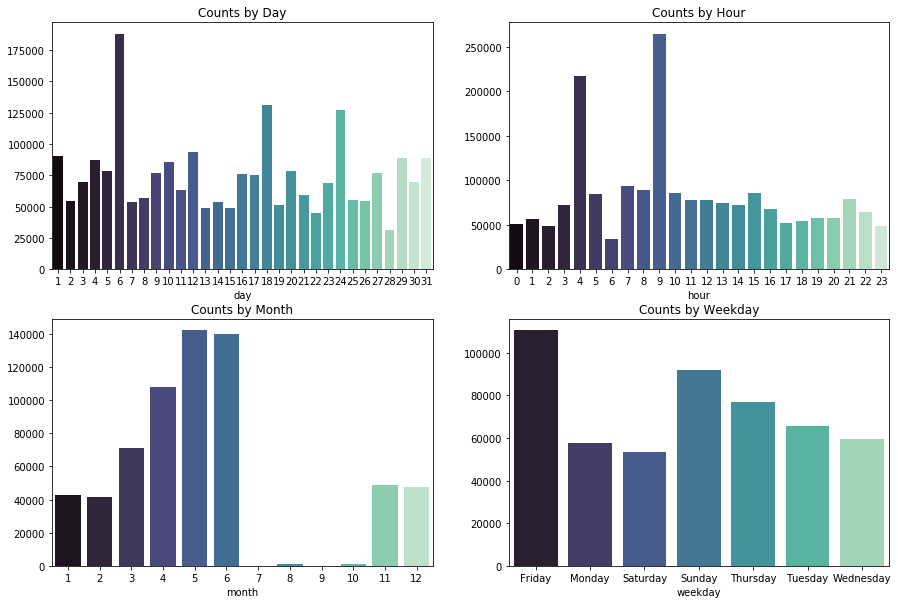

In [399]:
figure,axes = plt.subplots(2,2,figsize=(15,10))
plots = list(axes.flatten())
categories = ['day','hour','month', 'weekday']
for i, category in enumerate(categories):
    graph_counts = videos.groupby(category)['likes'].mean()
    plt.title('Count by ' + category.capitalize())
    sns.barplot(x=graph_counts.index, y=graph_counts.values, palette='mako', ax=plots[i])
    plots[i].set_title('Counts by '+category.capitalize())

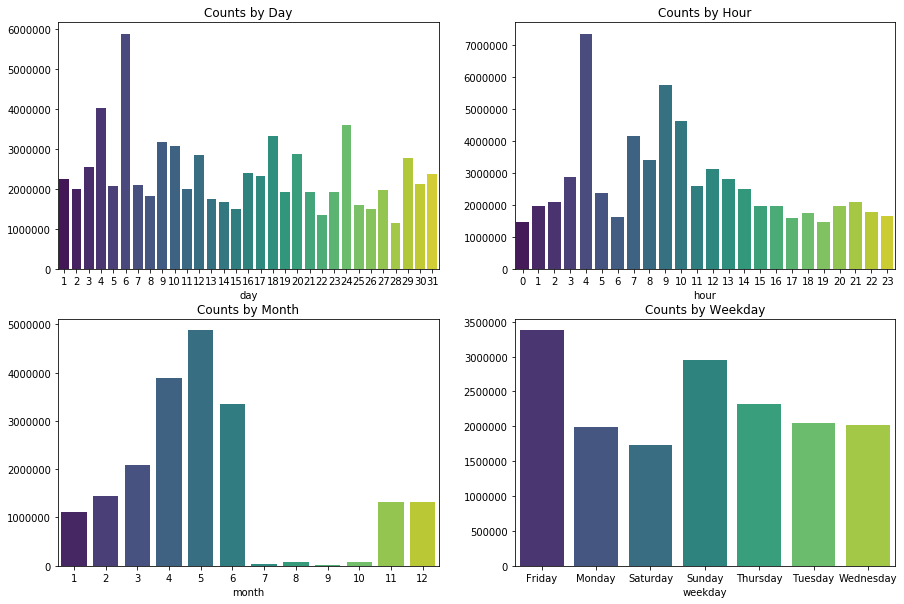

In [212]:
figure,axes = plt.subplots(2,2,figsize=(15,10))
plots = list(axes.flatten())
categories = ['day','hour','month', 'weekday']
for i, category in enumerate(categories):
    graph_counts = videos.groupby(category)['views'].mean()
    plt.title('Count by ' + category.capitalize())
    sns.barplot(x=graph_counts.index, y=graph_counts.values, palette='viridis', ax=plots[i])
    plots[i].set_title('Counts by '+category.capitalize())

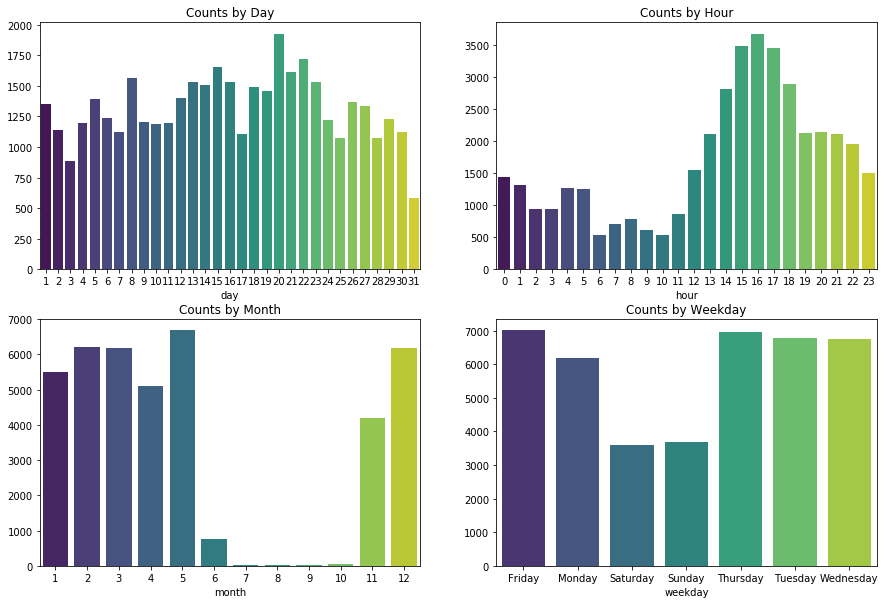

In [213]:
figure,axes = plt.subplots(2,2,figsize=(15,10))
plots = list(axes.flatten())
categories = ['day','hour','month', 'weekday']
for i, category in enumerate(categories):
    graph_counts = videos.groupby(category)['video_id'].count()
    plt.title('Count by ' + category.capitalize())
    sns.barplot(x=graph_counts.index, y=graph_counts.values, palette='viridis', ax=plots[i])
    plots[i].set_title('Counts by '+category.capitalize())

0                                          SHANtell martin
1        last week tonight trump presidency|"last week ...
2        racist superman|"rudy"|"mancuso"|"king"|"bach"...
3        rhett and link|"gmm"|"good mythical morning"|"...
4        ryan|"higa"|"higatv"|"nigahiga"|"i dare you"|"...
                               ...                        
40944    aarons animals|"aarons"|"animals"|"cat"|"cats"...
40945                                               [none]
40946    I gave safiya nygaard a perfect hair makeover ...
40947    Black Panther|"HISHE"|"Marvel"|"Infinity War"|...
40948        call of duty|"cod"|"activision"|"Black Ops 4"
Name: tags, Length: 40949, dtype: object